# Notebook for implementing ISCE2 interferometry to form Interferograms

https://nbviewer.org/github/isce-framework/isce2-docs/blob/master/Notebooks/UNAVCO_2020/TOPS/topsApp.ipynb

# First, some helpful functions

In [1]:
# importing needed libraries for the entire notebook in one go
# %matplotlib inline
# %matplotlib widget
import os
from dateutil.parser import parse as parse_date
from datetime import datetime
import pandas as pd
import numpy as np
from osgeo import gdal, osr
import matplotlib.pyplot as plt
import eof
import xml.etree.ElementTree as ET
import glob
import re

In [31]:
def project_dir(work_dir):
    """
    This function reads in a string that you wish to make your working directory 
    for the InSAR project, and creates a data directory to store the data for ISCE2 and mintpy
    work-dir = str
        path to the directory created in 01_get_slc.ipynb
    """

    #creates file on your desktop containing the work of this notebook
    os.makedirs(work_dir, exist_ok=True)
    
    # file inside work_dir for isce2 interferometry
    if_dir = os.path.join(work_dir,'InSAR/interferometry')
    os.makedirs(if_dir, exist_ok=True)
    
    # file inside work_dir for mintpy time-series
    ts_dir = os.path.join(work_dir,'InSAR/time_series')
    os.makedirs(ts_dir, exist_ok=True)
    

    xmls_dir = os.path.join(if_dir,'xmls')
    os.makedirs(xmls_dir, exist_ok=True)
    
    xmldirectories=[]
    for dir in ['topsApp', 'reference', 'secondary']:
        dirpath = os.path.join(xmls_dir, dir)
        os.makedirs(dirpath, exist_ok=True)
        xmldirectories.append(dirpath)

    ifdirectories=[]
    for dir in ['reference', 'secondary', 'orbits', 'work']:
        dirpath = os.path.join(if_dir, dir)
        os.makedirs(dirpath, exist_ok=True)
        ifdirectories.append(dirpath)

    tsdirectories=[]
    for dir in ['baselines', 'reference', 'merged', 'secondaries', 'mintpy']:
        dirpath = os.path.join(ts_dir, dir)
        os.makedirs(dirpath, exist_ok=True)
        if dir == 'merged':
                geomref_dir = os.path.join(dirpath,'geom_reference')
                os.makedirs(geomref_dir, exist_ok=True)

                interfer_dir = os.path.join(dirpath,'interferograms')
                os.makedirs(interfer_dir, exist_ok=True)

                tsdirectories.append(geomref_dir)
                tsdirectories.append(interfer_dir)

        tsdirectories.append(dirpath)

    return work_dir, ifdirectories, tsdirectories, xmldirectories

In [3]:
# function to create the reference and secondary .xml files needed for ISCE2 interferometry
# function to write the 
def ref_sec_xml(slc_zips_list, slc_zips_dirs):
    for i in range(len(slc_zips_dirs)):
        for j, type in enumerate(['reference', 'secondary']):
            imset = ET.Element('component', name=type)
            safe = ET.SubElement(imset, 'property', name='safe').text = slc_zips_dirs[i]
            out_dir =ET.SubElement(imset, 'property', name='output directory').text = ifdirectories[j]
            orbit_dir =ET.SubElement(imset, 'property', name='orbit directory').text = ifdirectories[2]
            roi = ET.SubElement(imset, 'property', name='region of interest').text = str(isce_aoi)
            tree = ET.ElementTree(imset)
            tree.write(os.path.join(xmldirectories[j+1], f'{slc_zips_list[i][17:25]}{type[:3]}.xml'))

In [4]:
def topsApp_xml(xmlname, do_iono, do_unwrap, isce_aoi):
    """
    Create a topsApp XML configuration file for Sentinel-1 InSAR processing.

    Parameters:
        xmlname (str): Name of the output XML file.
        do_iono (str): 'True' or 'False', to enable or disable ionospheric correction.
        do_unwrap (str): 'True' or 'False', to enable or disable phase unwrapping
        isce_aoi (list): Bounding box for processing [S, N, W, E].
    """

    data = ET.Element('topsApp')
    tinsar = ET.SubElement(data, 'component', name='topsinsar')

    # Sensor and DEM settings
    ET.SubElement(tinsar, 'property', name='sensor name').text = 'SENTINEL1'
    # ET.SubElement(tinsar, 'property', name='useHighResolutionDemOnly').text = str(True)
    # ET.SubElement(tinsar, 'property', name='demFilename').text = '/path/to/dem.tif'
    # ET.SubElement(tinsar, 'property', name='geocode demfilename').text = '/path/to/geocode_dem.tif'

    # Reference and Secondary catalogs
    ref_xmlcomp = ET.SubElement(tinsar, 'component', name='reference')
    ET.SubElement(ref_xmlcomp, 'catalog').text = os.path.join(xmldirectories[1], f"{xmlname[:8]}ref.xml")
    sec_xmlcomp = ET.SubElement(tinsar, 'component', name='secondary')
    ET.SubElement(sec_xmlcomp, 'catalog').text = os.path.join(xmldirectories[2], f"{xmlname[9:17]}sec.xml")

    # General processing settings
    ET.SubElement(tinsar, 'property', name='swaths').text = str([3])
    ET.SubElement(tinsar, 'property', name='azimuth looks').text = str(1)
    ET.SubElement(tinsar, 'property', name='range looks').text = str(5)
    ET.SubElement(tinsar, 'property', name='region of interest').text = str(isce_aoi)
    ET.SubElement(tinsar, 'property', name='filter strength').text = str(0.2)

    # Unwrapping settings
    ET.SubElement(tinsar, 'property', name='do unwrap').text = str(do_unwrap)
    ET.SubElement(tinsar, 'property', name='unwrapper name').text = 'snaphu_mcf'
    # ET.SubElement(tinsar, 'property', name='do unwrap 2 stage').text = str(False)
    # ET.SubElement(tinsar, 'property', name='unwrapper 2stage name').text = 'REDARC0'
    # ET.SubElement(tinsar, 'property', name='SOLVER_2STAGE').text = 'pulp'

    # ESD settings
    ET.SubElement(tinsar, 'property', name='do ESD').text = str(True)
    ET.SubElement(tinsar, 'property', name='ESD azimuth looks').text = str(1)
    ET.SubElement(tinsar, 'property', name='ESD range looks').text = str(5)
    ET.SubElement(tinsar, 'property', name='ESD coherence threshold').text = str(0.85)
    ET.SubElement(tinsar, 'property', name='extra ESD cycles').text = str(1)

    # Dense offset settings
    ET.SubElement(tinsar, 'property', name='do dense offsets').text = str(True)
    ET.SubElement(tinsar, 'property', name='Ampcor window width').text = str(64)
    ET.SubElement(tinsar, 'property', name='Ampcor window height').text = str(64)
    ET.SubElement(tinsar, 'property', name='Ampcor search window width').text = str(20)
    ET.SubElement(tinsar, 'property', name='Ampcor search window height').text = str(20)
    ET.SubElement(tinsar, 'property', name='Ampcor skip width').text = str(32)
    ET.SubElement(tinsar, 'property', name='Ampcor skip height').text = str(32)
    ET.SubElement(tinsar, 'property', name='Ampcor margin').text = str(50)
    ET.SubElement(tinsar, 'property', name='Ampcor oversampling factor').text = str(32)
    ET.SubElement(tinsar, 'property', name='Range shift').text = str(0)
    ET.SubElement(tinsar, 'property', name='Azimuth shift').text = str(0)
    ET.SubElement(tinsar, 'property', name='SNR Threshold factor').text = str(8.0)

    # Water masking
    # ET.SubElement(tinsar, 'property', name='apply water mask').text = str(True)
    # ET.SubElement(tinsar, 'property', name='water mask file name').text = '/path/to/water_mask.wbd'

    # Ionospheric correction
    if do_iono == 'True':
        ET.SubElement(tinsar, 'property', name='do ionosphere correction').text = do_iono
        ET.SubElement(tinsar, 'property', name='apply ionosphere correction').text = do_iono
        ET.SubElement(tinsar, 'property', name='start ionosphere step').text = 'subband'
        ET.SubElement(tinsar, 'property', name='end ionosphere step').text = 'esd'
        ET.SubElement(tinsar, 'property', name='height of ionosphere layer in km').text = str(200.0)
        ET.SubElement(tinsar, 'property', name='apply polynomial fit before filtering ionosphere phase').text = str(True)
        ET.SubElement(tinsar, 'property', name='maximum window size for filtering ionosphere phase').text = str(200)
        ET.SubElement(tinsar, 'property', name='minimum window size for filtering ionosphere phase').text = str(100)
        ET.SubElement(tinsar, 'property', name='maximum window size for filtering ionosphere azimuth shift').text = str(150)
        ET.SubElement(tinsar, 'property', name='minimum window size for filtering ionosphere azimuth shift').text = str(75)
        ET.SubElement(tinsar, 'property', name='correct phase error caused by ionosphere azimuth shift').text = str(2)

    # Save XML
    tree = ET.ElementTree(data)
    tree.write(os.path.join(xmldirectories[0], xmlname))

In [5]:
# took these from UNAVCO for plotting the results from topsApp

# Utility to plot a 2D array
def plotdata(GDALfilename, band=1,
             title=None,colormap='gray',
             aspect=1, background=None,
             datamin=None, datamax=None,
             interpolation='nearest',
             nodata = None,
             draw_colorbar=True, colorbar_orientation="horizontal"):
    
    # Read the data into an array
    ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
    data = ds.GetRasterBand(band).ReadAsArray()
    transform = ds.GetGeoTransform()
    ds = None
    
    try:
        if nodata is not None:
            data[data == nodata] = np.nan
    except:
        pass
        
    # getting the min max of the axes
    firstx = transform[0]
    firsty = transform[3]
    deltay = transform[5]
    deltax = transform[1]
    lastx = firstx+data.shape[1]*deltax
    lasty = firsty+data.shape[0]*deltay
    ymin = np.min([lasty,firsty])
    ymax = np.max([lasty,firsty])
    xmin = np.min([lastx,firstx])
    xmax = np.max([lastx,firstx])

    # put all zero values to nan and do not plot nan
    if background is None:
        try:
            data[data==0]=np.nan
        except:
            pass
    
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(111)
    cax = ax.imshow(data, vmin = datamin, vmax=datamax,
                    cmap=colormap, extent=[xmin,xmax,ymin,ymax],
                    interpolation=interpolation)
    ax.set_title(title)
    if draw_colorbar is not None:
        cbar = fig.colorbar(cax,orientation=colorbar_orientation)
    ax.set_aspect(aspect)    
    plt.show()
    
    # clearing the data
    data = None

# Utility to plot interferograms
def plotcomplexdata(GDALfilename,
                    title=None, aspect=1,
                    datamin=None, datamax=None,
                    interpolation='nearest',
                    draw_colorbar=None, colorbar_orientation="horizontal"):
    # Load the data into numpy array
    ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
    slc = ds.GetRasterBand(1).ReadAsArray()
    transform = ds.GetGeoTransform()
    ds = None
    
    # getting the min max of the axes
    firstx = transform[0]
    firsty = transform[3]
    deltay = transform[5]
    deltax = transform[1]
    lastx = firstx+slc.shape[1]*deltax
    lasty = firsty+slc.shape[0]*deltay
    ymin = np.min([lasty,firsty])
    ymax = np.max([lasty,firsty])
    xmin = np.min([lastx,firstx])
    xmax = np.max([lastx,firstx])

    # put all zero values to nan and do not plot nan
    try:
        slc[slc==0]=np.nan
    except:
        pass

    
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(1,2,1)
    cax1=ax.imshow(np.abs(slc), vmin = datamin, vmax=datamax,
                   cmap='gray', extent=[xmin,xmax,ymin,ymax],
                   interpolation=interpolation)
    ax.set_title(title + " (amplitude)")
    if draw_colorbar is not None:
        cbar1 = fig.colorbar(cax1,orientation=colorbar_orientation)
    ax.set_aspect(aspect)

    ax = fig.add_subplot(1,2,2)
    cax2 =ax.imshow(np.angle(slc), cmap='rainbow',
                    vmin=-np.pi, vmax=np.pi,
                    extent=[xmin,xmax,ymin,ymax],
                    interpolation=interpolation)
    ax.set_title(title + " (phase [rad])")
    if draw_colorbar is not None:
        cbar2 = fig.colorbar(cax2, orientation=colorbar_orientation)
    ax.set_aspect(aspect)
    plt.show()
    
    # clearing the data
    slc = None

# Utility to plot multiple similar arrays
def plotstackdata(GDALfilename_wildcard, band=1,
                  title=None, colormap='gray',
                  aspect=1, datamin=None, datamax=None,
                  interpolation='nearest',
                  draw_colorbar=True, colorbar_orientation="horizontal"):
    # get a list of all files matching the filename wildcard criteria
    GDALfilenames = glob.glob(GDALfilename_wildcard)
    
    # initialize empty numpy array
    data = None
    for GDALfilename in GDALfilenames:
        ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
        data_temp = ds.GetRasterBand(band).ReadAsArray()   
        ds = None
        
        if data is None:
            data = data_temp
        else:
            data = np.vstack((data,data_temp))

    # put all zero values to nan and do not plot nan
    try:
        data[data==0]=np.nan
    except:
        pass            
            
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(111)
    cax = ax.imshow(data, vmin = datamin, vmax=datamax,
                    cmap=colormap, interpolation=interpolation)
    ax.set_title(title)
    if draw_colorbar is not None:
        cbar = fig.colorbar(cax,orientation=colorbar_orientation)
    ax.set_aspect(aspect)    
    plt.show() 

    # clearing the data
    data = None

# Utility to plot multiple simple complex arrays
def plotstackcomplexdata(GDALfilename_wildcard,
                         title=None, aspect=1,
                         datamin=None, datamax=None,
                         interpolation='nearest',
                         draw_colorbar=True, colorbar_orientation="horizontal"):
    # get a list of all files matching the filename wildcard criteria
    GDALfilenames = glob.glob(GDALfilename_wildcard)
    print(GDALfilenames)
    # initialize empty numpy array
    data = None
    for GDALfilename in GDALfilenames:
        ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
        data_temp = ds.GetRasterBand(1).ReadAsArray()
        ds = None
        
        if data is None:
            data = data_temp
        else:
            data = np.vstack((data,data_temp))

    # put all zero values to nan and do not plot nan
    try:
        data[data==0]=np.nan
    except:
        pass              
            
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(1,2,1)
    cax1=ax.imshow(np.abs(data), vmin=datamin, vmax=datamax,
                   cmap='gray', interpolation='nearest')
    ax.set_title(title + " (amplitude)")
    if draw_colorbar is not None:
        cbar1 = fig.colorbar(cax1,orientation=colorbar_orientation)
    ax.set_aspect(aspect)

    ax = fig.add_subplot(1,2,2)
    cax2 =ax.imshow(np.angle(data), cmap='rainbow',
                            interpolation='nearest')
    ax.set_title(title + " (phase [rad])")
    if draw_colorbar is not None:
        cbar2 = fig.colorbar(cax2,orientation=colorbar_orientation)
    ax.set_aspect(aspect)
    plt.show() 
    
    # clearing the data
    data = None

# Establish working directory and data paths

In [32]:
# Establish working directories, and locate Sentinel-1 SLC .zip files
proj_dir = '/home/wcc/Desktop/SabineRS'
work_dir = os.path.join(proj_dir, 'Sentinel-1')
work_dir, ifdirectories, tsdirectories, xmldirectories = project_dir(work_dir)

In [ ]:
# assuming you have downloaded .zip files covering your AOI from ASF Vertex
# enter the file directory below
slc_zips = os.path.join(work_dir, 'SLC/ASCENDING/136/93')

slc_zips_list = sorted(os.listdir(slc_zips), key=lambda x: datetime.strptime(x[17:25], '%Y%m%d'))
slc_zips_dirs = [os.path.join(slc_zips, slc) for slc in slc_zips_list]
slc_zips_dates = [slc[17:25] for slc in slc_zips_list]

# Get bbox drawn in 01_get_slc.ipynb

In [15]:
isce_aoi_file = open(os.path.join(proj_dir, 'isceaoi.txt'), 'r+')
aoi = isce_aoi_file.read()
isce_aoi = [float(num) for num in re.findall(r'[-+]?\d*\.\d+', aoi)]

# Get s-1 orbit files (.EOF) using sentineleof library

In [ ]:
#below downloads orbit files for your S1 SLC imagery to orbits_dir created with project_dir
for i,slc in enumerate(slc_zips_list):
    eof.download.download_eofs(
        orbit_dts=slc_zips_dates[i],  # slc date in str YYYYMMDD format
        missions=['S1A', 'S1B'],        # gets both S1 missions, third was just launched (2024) so may need updating
        sentinel_file=slc,              # image name
        save_dir=ifdirectories[2],      # orbits_dir
        orbit_type='precise'            # can be 'precise' or 'restituted'
    )

# Create Sentinel-1 SLC .xml files
- One reference and one secondary for each image

In [16]:
ref_sec_xml(slc_zips_list, slc_zips_dirs)

# Create topsApp.xml file
- look into computing baselines, running dense offsets for wrapped and unwrapped ifgs, water masking, shadow masking, and ionosphere correction
- one for each interferogram in each triplet

in order of importance
1. water mask in radar and for mintpy (wbd.py)
3. compute baselines
4.  automation for all SLCs (including removing old data and organizing to mintpy standards)
5. shadow masking

In [18]:
slc_zips_list

['S1A_IW_SLC__1SDV_20191001T001837_20191001T001904_029258_035306_76D9.zip',
 'S1A_IW_SLC__1SDV_20191013T001837_20191013T001904_029433_035905_4924.zip',
 'S1A_IW_SLC__1SDV_20191106T001837_20191106T001904_029783_036530_4CA8.zip',
 'S1A_IW_SLC__1SDV_20191118T001837_20191118T001904_029958_036B4F_FD42.zip',
 'S1A_IW_SLC__1SDV_20191130T001837_20191130T001904_030133_03715E_A9CE.zip',
 'S1A_IW_SLC__1SDV_20191212T001836_20191212T001903_030308_037763_4B09.zip',
 'S1A_IW_SLC__1SDV_20200117T001835_20200117T001902_030833_03899B_EB9D.zip',
 'S1A_IW_SLC__1SDV_20200129T001834_20200129T001901_031008_038FC5_3E97.zip',
 'S1A_IW_SLC__1SDV_20200210T001834_20200210T001901_031183_0395DE_D89E.zip',
 'S1A_IW_SLC__1SDV_20200317T001834_20200317T001901_031708_03A800_1BFE.zip',
 'S1A_IW_SLC__1SDV_20200329T001834_20200329T001901_031883_03AE27_23CB.zip',
 'S1A_IW_SLC__1SDV_20200410T001834_20200410T001902_032058_03B45A_D08A.zip',
 'S1A_IW_SLC__1SDV_20200422T001835_20200422T001902_032233_03BA79_4D19.zip',
 'S1A_IW_SLC

In [19]:
# first, need to get baseline wrapped geocoded ifg
# will be used to get sentinel-2 imagery for water mask
# stores these in xmldirectories[0]

do_iono = 'True'    # most times C-band is unaffected by ionosphere, but it is good to include
do_unwrap = 'False'

# create the xml
topsApp_xml(f'{slc_zips_list[0][17:25]}_{slc_zips_list[1][17:25]}topsApp.xml', do_iono, do_unwrap, isce_aoi)

# topsApp interferometry (finally!)
- Need to split interferogram processing into three steps
1. preprocess to filter
2. apply water mask
3. unwrap to endup

In [20]:
# check that you have isce installed and what version

import isce
isce.version.release_version

Using default ISCE Path: /home/wcc/tools/miniforge/envs/isce/lib/python3.8/site-packages/isce


'2.6.3'

In [21]:
# this is used to change directory into the storage directory for all interferograms
# should be used, else will save results to github repo
os.chdir(ifdirectories[3])
print(ifdirectories[3])

/home/wcc/Desktop/SabineRS/Sentinel-1/InSAR/interferometry/work


Run isce2 up to the unwrapping stage, this will provide the wrapped interferogram. The boundings of this wrapped interferogram will then be used to retrieve the needed Sentinel-1 and Sentinel-2 imagery for the water mask model.

# Baseline interferogram and water mask creation

In [22]:
# initialize the reference interferogram and SLC for mintpy
# run in steps from preprocess to filter

xml_path = os.path.join(xmldirectories[0] , sorted(os.listdir(xmldirectories[0]), key=lambda x: datetime.strptime(x[:8], '%Y%m%d'))[0])

In [23]:
!topsApp.py {xml_path} --steps

2024-12-11 09:18:56,697 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
Step processing
Running step startup
None
The currently supported sensors are:  ['SENTINEL1']
Dumping the application's pickle object _insar to file  PICKLE/startup
The remaining steps are (in order):  ['preprocess', 'computeBaselines', 'verifyDEM', 'topo', 'subsetoverlaps', 'coarseoffsets', 'coarseresamp', 'overlapifg', 'prepesd', 'esd', 'rangecoreg', 'fineoffsets', 'fineresamp', 'ion', 'burstifg', 'mergebursts', 'filter', 'unwrap', 'unwrap2stage', 'geocode', 'denseoffsets', 'filteroffsets', 'geocodeoffsets']
Running step preprocess
Input XML files:  ['/vsizip//home/wcc/Desktop/SabineRS/Sentinel-1/InSAR/0_initial/ASCENDING/136/93/S1A_IW_SLC__1SDV_20191001T001837_20191001T001904_029258_035306_76D9.zip/S1A_IW_SLC__1SDV_20191001T001837_20191001T001904_0292

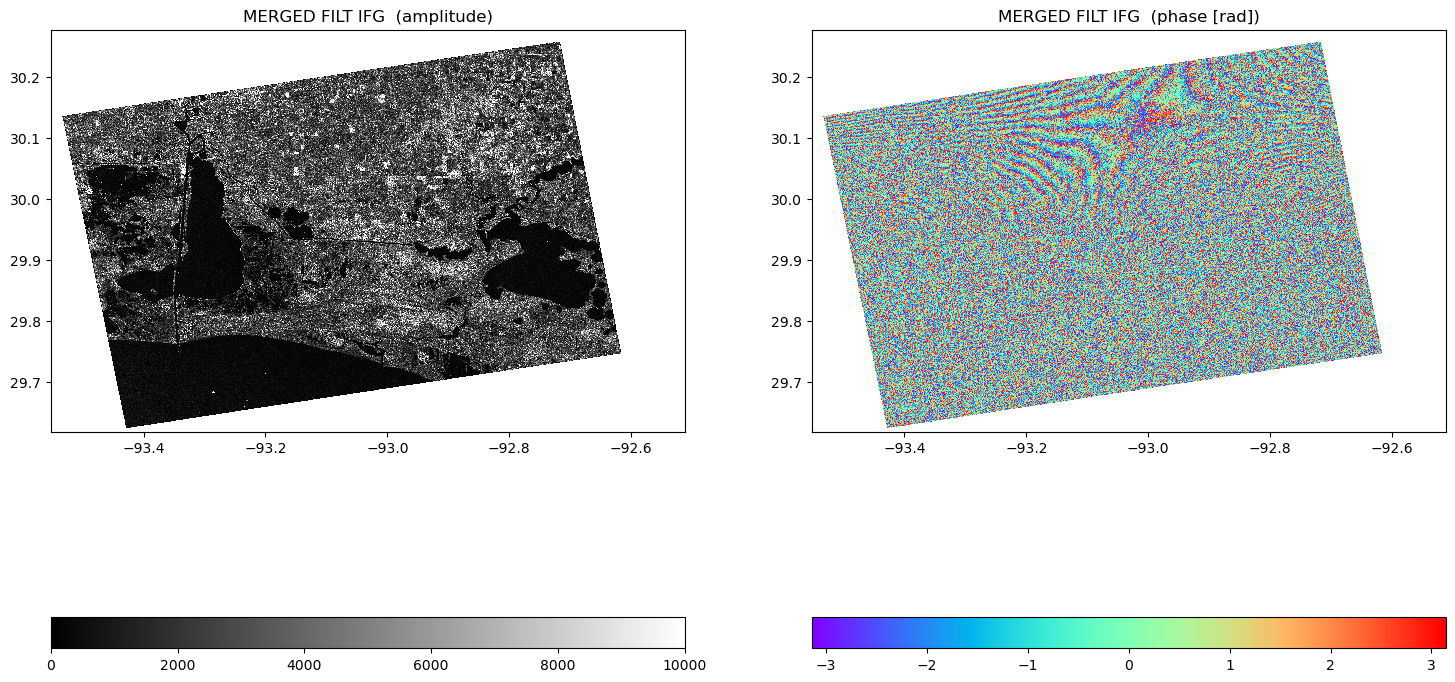

In [26]:
#quickly visualize the filtered amplitude and the filtered wrapped ifg

plotcomplexdata('merged/filt_topophase.flat.geo.vrt', 
                title="MERGED FILT IFG ", aspect=1,
                datamin=0, datamax=10000, draw_colorbar=True)

Use the initial, non water masked, baseline ifg to get the bbox for 02b_get_sentinel_one_two.ipynb. Once you have the water mask generated, come back here and rerun the baseline ifg including the water mask (and ionosphere correction if you want). Make sure to remake all the topsApp.xml so they include the water mask (and ion settings if needed).

Once you have the bounding box for the wrapped ifg, go to the water mask model and go through that workflow until you have the mode of the water mask for the entire Sentinel-1 time series (either develop a new model for your aoi, or leverage an already created model for existing aois's). Once you have this mode water mask, come back here and load it in.

In [ ]:
# load the water mask


In [ ]:
# remake the xmls to contain ionosphere correction (if you want)
# stores these in xmldirectories[0]

# do_iono = 'True'

# for i, m in enumerate(slc_zips_list):
#     if i < len(slc_zips_list) - 4:
#         for date in [f'{m[17:25]}_{slc_zips_list[i+1][17:25]}', f'{m[17:25]}_{slc_zips_list[i+2][17:25]}', f'{m[17:25]}_{slc_zips_list[i+3][17:25]}']:
#             topsApp_xml(f'{date}topsApp.xml', do_iono, isce_aoi)

#     elif i == len(slc_zips_list) - 3:
#         for date in [f'{m[17:25]}_{slc_zips_list[i+1][17:25]}', f'{m[17:25]}_{slc_zips_list[i+2][17:25]}']:
#             topsApp_xml(f'{date}topsApp.xml', do_iono, isce_aoi)

#     elif i == len(slc_zips_list) - 2:
#         topsApp_xml(f"{m[17:25]}_{slc_zips_list[i+1][17:25]}topsApp.xml", do_iono, isce_aoi)

#     elif i == len(slc_zips_list) - 1:
#         break

Once you have loaded the water mask in this notebook, use isce2 to apply the water mask to the wrapped ifg.

In [ ]:
# first create appropriate XMLs
# this is for all ifgs

do_iono = 'True'
do_unwrap = 'True'

for i, m in enumerate(slc_zips_list):
    if i < len(slc_zips_list) - 4:
        for date in [f'{m[17:25]}_{slc_zips_list[i+1][17:25]}', f'{m[17:25]}_{slc_zips_list[i+2][17:25]}', f'{m[17:25]}_{slc_zips_list[i+3][17:25]}']:
            topsApp_xml(f'{date}topsApp.xml', do_iono, do_unwrap, isce_aoi)

    elif i == len(slc_zips_list) - 3:
        for date in [f'{m[17:25]}_{slc_zips_list[i+1][17:25]}', f'{m[17:25]}_{slc_zips_list[i+2][17:25]}']:
            topsApp_xml(f'{date}topsApp.xml', do_iono, do_unwrap, isce_aoi)

    elif i == len(slc_zips_list) - 2:
        topsApp_xml(f"{m[17:25]}_{slc_zips_list[i+1][17:25]}topsApp.xml", do_iono, do_unwrap, isce_aoi)

    elif i == len(slc_zips_list) - 1:
        break

In [ ]:
!topsApp.py {xml_path} --start='startup' --end='filter'

With the water masked wrapped ifg, you can now proceed with unwrapping.

In [ ]:
# step processing here
# do unwrapping to the finish


# Secondary interferogram(s) generation

Now, reuse the watermask and bulk process the secondary ifg's needed for the insar time series. This replicates the above water masking, but for each subsequent ifg in the time series

In [ ]:
# secondary interferograms
# step processing to unwrap again

for xml in sorted(os.listdir(xmldirectories[0]), key=lambda x: datetime.strptime(x[:8], '%Y%m%d'))[1:]:
    xml_path = os.path.join(xmldirectories[0] , xml)
    insar = TopsInSAR(name="topsApp", cmdline=xml_path)
    insar.configure()
    insar.run()

In [ ]:
# step processing here
#do preprocess to filter


In [ ]:
# use wbd.py or waterMask.py to retrieve and download needed watermask
# apply watermask (using isce2, or manually with gdal and rasterio)


In [ ]:
# continue with InSAR using the water masked data for unwrapping
# do unwrap to endup


In [ ]:
# can run these steps separately if you want more info on where process may be failing

# insar = TopsInSAR(name="topsApp", cmdline=xml_path)
# insar.configure()
# insar.startup()
# insar.runComputeBaseline()
# insar.verifyDEM()
# insar.verifyGeocodeDEM()
# insar.runTopo()
# insar.runSubsetOverlaps()
# insar.runCoarseOffsets()
# insar.runCoarseResamp()
# insar.runOverlapIfg()
# insar.runPrepESD()
# insar.runESD()
# insar.runRangeCoreg()
# insar.runFineOffsets()
# insar.runFineResamp()
# insar.runIon()
# insar.runBurstIfg()
# insar.runMergeBursts()
# #add dense offsets here for wrapped phase if you'd like
# insar.runFilter()
# insar.runUnwrapper()    # can also run 2stage unwrapper and dump to pickle if you want
# insar.runGeocode(insar.geocode_list, insar.do_unwrap, insar.geocode_bbox)
# insar.runDenseOffsets()
# insar.runOffsetFilter()
# insar.runGeocode(insar.off_geocode_list, True, insar.geocode_bbox, True)
# insar.endup()

Steps include:
- runPreprocessor
- runComputeBaseline
- verifyDEM
- verifyGeocodeDEM
- runTopo
- runSubsetOverlaps
- runCoarseOffsets
- runCoarseResamp
- runOverlapIfg
- runPrepESD
- runESD
- runRangeCoreg
- runFineOffsets
- runFineResamp
- runIon
- runBurstIfg
- runMergeBursts
- runFilter
- runGeocode
- runDenseOffsets
- runOffsetFilter

# Generate baseline file for interferograms
- uses isce2/contrib/stack/topsStack/computeBaseline.py, you will need to provide your path

# Arrange file directories for use in MintPy
- https://github.com/insarlab/MintPy-tutorial/blob/main/workflows/smallbaselineApp.ipynb
- reference the Fernandina example set
- for 'reference' and 'merged/reference' files, only needed from first ifg
- remove files not needed in mintpy to save storage space

NEED TO FIGURE THIS OUT FIRST, AUTOMATION ALREADY WORKS BUT OVERWRITES ITSELF

# Generate smallbaselineApp files needed for MintPy time series (might have to run this in mintpy environment)
- need prep_isce and load_data from MintPy
- https://mintpy.readthedocs.io/en/stable/dir_structure/

In [ ]:
# mintpy needs

# mintpy.load.processor        = isce
# ##---------for ISCE only:
# mintpy.load.metaFile         = $DATA_DIR/GalapagosSenDT128/reference/IW*.xml
# mintpy.load.baselineDir      = $DATA_DIR/GalapagosSenDT128/baselines
# ##---------interferogram datasets:
# mintpy.load.unwFile          = $DATA_DIR/GalapagosSenDT128/merged/interferograms/*/filt_*.unw
# mintpy.load.corFile          = $DATA_DIR/GalapagosSenDT128/merged/interferograms/*/filt_*.cor
# mintpy.load.connCompFile     = $DATA_DIR/GalapagosSenDT128/merged/interferograms/*/filt_*.unw.conncomp
# ##---------geometry datasets:
# mintpy.load.demFile          = $DATA_DIR/GalapagosSenDT128/merged/geom_reference/hgt.rdr
# mintpy.load.lookupYFile      = $DATA_DIR/GalapagosSenDT128/merged/geom_reference/lat.rdr
# mintpy.load.lookupXFile      = $DATA_DIR/GalapagosSenDT128/merged/geom_reference/lon.rdr
# mintpy.load.incAngleFile     = $DATA_DIR/GalapagosSenDT128/merged/geom_reference/los.rdr
# mintpy.load.azAngleFile      = $DATA_DIR/GalapagosSenDT128/merged/geom_reference/los.rdr
# mintpy.load.shadowMaskFile   = $DATA_DIR/GalapagosSenDT128/merged/geom_reference/shadowMask.rdr

